---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [168]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

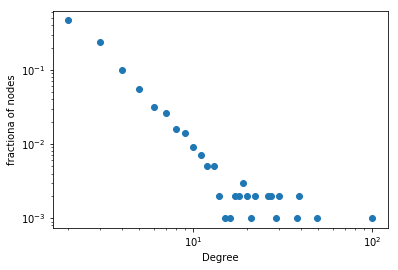

The ave shortest path and ave CC is: 4.099161, 0.031675


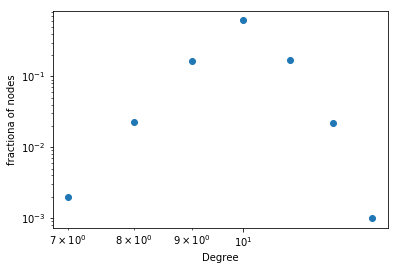

The ave shortest path and ave CC is: 5.089872, 0.564242


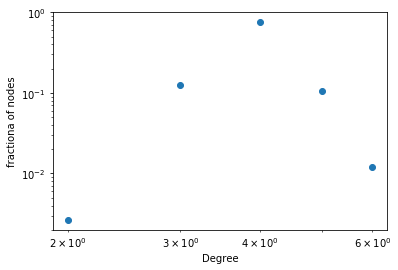

The ave shortest path and ave CC is: 9.378702, 0.401822


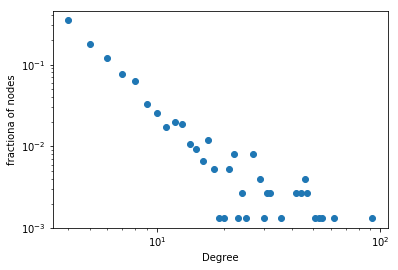

The ave shortest path and ave CC is: 3.104805, 0.037804


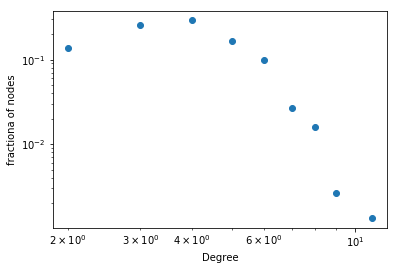

The ave shortest path and ave CC is: 5.078551, 0.003304


In [190]:
import matplotlib.pyplot as plt

for G in P1_Graphs:
    degrees = G.degree()
    
    # a list of unique degrees found in the network
    degree_values = sorted(set(degrees.values()))
    
    # the number of times a degree is present in the network divided by the number of nodes
    hist = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    
    # computes average shortest path length
    ave_path = nx.average_shortest_path_length(G)
    
    # computes average clustering coefficient
    ave_clus = nx.average_clustering(G)
    
    plt.plot(degree_values, hist, "o")
    plt.xlabel("Degree")
    plt.ylabel("fractiona of nodes")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    print("The ave shortest path and ave CC is: {:3f}, {:3f}".format(ave_path,ave_clus))

In [4]:
def graph_identification():
    
    # 1 and 4 show a linear power law so they are  preferentially attached (PA)
    # 2 and 3 have high average clustering coefficients so they are probably have low values of P (SW_L)
    # 5 has a low average clustering coefficient so its likely to have a high value of P (SW_H)
    
    return ["PA", "SW_L", "SW_L", "PA", "SW_H"]

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [5]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [6]:
#G.nodes(data=True)

In [147]:
import pandas as pd
import numpy as np

# Turn the node data into a dataframe
df = pd.DataFrame(G.nodes(data=True), columns=["Node", "Diction"])

# Take the dictionary data and turn it into 2 columns of data
df["Dep"] = df["Diction"].map(lambda x: x["Department"])
df["MS"] = df["Diction"].map(lambda x: x["ManagementSalary"])
df.drop(labels="Diction", axis=1, inplace=True)
#df.set_index("Node",inplace=True)
df.head()

,Node,Dep,MS
0,0,1,0.0
1,1,1,NaN
2,2,21,NaN
3,3,21,1.0
4,4,21,1.0


In [8]:
## average clustering coefficient, important nodes are connected to nodes that are connected to each other
#df["ave.CC"] = df["Node"].apply(lambda x: nx.clustering(G,x))
#
## important nodes are highly connected
#degCent = nx.degree_centrality(G)
#df["Degree Cent"] = df["Node"].apply(lambda x: degCent[x])
#
## important nodes are central in the network
#closeCent = nx.closeness_centrality(G)
#df["Closeness Cent"] = df["Node"].apply(lambda x: closeCent[x])
#
## important nodes connect other nodes
#btwnCent = nx.betweenness_centrality(G, normalized=True)
#df["Betweenness Cent"] = df["Node"].apply(lambda x: btwnCent[x])
#
## find the betweenness centraility for subset, where subsets are the departments
#departments = list(df["Dep"].unique())
#
## creates a dictionary with keys as departmetns and values as nodes in the department
#subsets = {}
#for dep in departments:
#    values = []
#    for n in G.nodes(data=True):
#        if n[1]["Department"] == dep:
#            values.append(n[0])
#    subsets[dep] = values
#    
## important people connect the two largest departments
#top_deps = sorted([(k,len(v)) for k,v in subsets.items()], key=lambda x: x[1], reverse=True)[0:2]
#btwnCentSub = nx.betweenness_centrality_subset(G, subsets[top_deps[0][0]], subsets[top_deps[1][0]])
#
#df["Betweenness Cent Sub"] = df["Node"].apply(lambda x: btwnCentSub[x])
#
## important nodes are closest to other nodes
#df["Mean Shortest Path"] = df["Node"].apply(lambda x: np.mean(list(nx.shortest_path_length(G,x).values())))

In [9]:
#df.head()

In [10]:
## network isn't connected...
#nx.is_connected(G)

In [11]:
#sorted(nx.connected_components(G))

In [12]:
## list of nodes not connected to any other nodes
#dis_nodes = [i[0] for i in [list(x) for x in sorted(nx.connected_components(G))] if len(i) == 1]
#
#for n in dis_nodes:
#    print(G.node[n])

In [13]:
## 0 if not connected to the main network, and 1 if they are
#df["Connected"] = df["Node"].apply(lambda x: 0 if x in dis_nodes else 1)
#
## make nodes column the index
#df.set_index("Node", inplace=True)
#
#df.head()

In [14]:
## split df into train, test, and validation. with the validation being all MS = NaN
#from sklearn.model_selection import train_test_split
#
#df_train_test = df[(df["MS"] == 1) | (df["MS"] == 0)]
#validation = df[(df["MS"] != 1) & (df["MS"] != 0)]
#validation.drop(labels="MS", axis=1, inplace=True)
#
## split into labels and features
#y = df_train_test["MS"]
#X = df_train_test.drop(labels="MS", axis=1)
#
## split the data into train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [15]:
## Scale the data
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#validation_scalced = scaler.transform(validation)

In [16]:
## Train default models
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_curve, auc
#
#svc_model = SVC().fit(X_train_scaled, y_train)
#svm_pred = svc_model.predict(X_test_scaled)
#y_scores = svc_model.decision_function(X_test_scaled)
#fpr, tpr, _ = roc_curve(y_test, y_scores)
#
#print("Default SVC Test Accuracy: {:0.3f}".format(svc_model.score(X_test_scaled,y_test)))
#print("Default SVC Train Accuracy: {:0.3f}".format(svc_model.score(X_train_scaled,y_train)))
#print("Default SVC Test ROC: {:0.3f}".format(auc(fpr, tpr)))

In [17]:
#lr_model = LogisticRegression().fit(X_train_scaled, y_train)
#lr_pred = lr_model.predict(X_test_scaled)
#y_scores = lr_model.decision_function(X_test_scaled)
#y_scores_pr = lr_model.predict_proba(X_test_scaled)
#fpr, tpr, _ = roc_curve(y_test, y_scores)
#
#print("Default LR Test Accuracy: {:0.3f}".format(lr_model.score(X_test_scaled,y_test)))
#print("Default LR Train Accuracy: {:0.3f}".format(lr_model.score(X_train_scaled,y_train)))
#print("Default LR Test ROC: {:0.3f}".format(auc(fpr, tpr)))

In [18]:
#from sklearn.model_selection import cross_val_score, GridSearchCV
#
#X_scaled = scaler.transform(X)
#
#grid = {"penalty":["l2"], "C": [0.01,0.1,1,2,5,10]}
#
#lr_model_tuned = GridSearchCV(LogisticRegression(), param_grid=grid, n_jobs=7)
#lr_model_tuned.fit(X_train_scaled, y_train)
#
#params_lr = lr_model_tuned.best_params_
#
#lr_model = LogisticRegression(penalty = params_lr["penalty"],
#                             C = params_lr["C"])
#
#cv_score_lr = cross_val_score(lr_model, X_scaled, y, cv=5, n_jobs=7, scoring="roc_auc")

In [19]:
#print("Tuned LR Cross Validation Mean AUC Score: {:.3f}".format(cv_score_lr.mean()))
#print("LR Final Parameters: ", params_lr)

In [20]:
#lr_model = lr_model.fit(X_scaled, y)
#y_scores_pr_val = lr_model.predict_proba(validation_scalced)

In [21]:
#y_scores_pr_val

In [22]:
#answer = pd.Series(data = list(y_scores_pr_val[:,1]), index=validation.index)
#answer

In [23]:
#sorted(list(zip(validation.index,list(lr_pred))))

In [24]:
def salary_predictions():

    # Turn the node data into a dataframe
    df = pd.DataFrame(G.nodes(data=True), columns=["Node", "Diction"])

    # Take the dictionary data and turn it into 2 columns of data
    df["Dep"] = df["Diction"].map(lambda x: x["Department"])
    df["MS"] = df["Diction"].map(lambda x: x["ManagementSalary"])
    df.drop(labels="Diction", axis=1, inplace=True)
    
    # average clustering coefficient, important nodes are connected to nodes that are connected to each other
    df["ave.CC"] = df["Node"].apply(lambda x: nx.clustering(G,x))

    # important nodes are highly connected
    degCent = nx.degree_centrality(G)
    df["Degree Cent"] = df["Node"].apply(lambda x: degCent[x])

    # important nodes are central in the network
    closeCent = nx.closeness_centrality(G)
    df["Closeness Cent"] = df["Node"].apply(lambda x: closeCent[x])

    # important nodes connect other nodes
    btwnCent = nx.betweenness_centrality(G, normalized=True)
    df["Betweenness Cent"] = df["Node"].apply(lambda x: btwnCent[x])

    # find the betweenness centraility for subset, where subsets are the departments
    departments = list(df["Dep"].unique())

    # creates a dictionary with keys as departmetns and values as nodes in the department
    subsets = {}
    for dep in departments:
        values = []
        for n in G.nodes(data=True):
            if n[1]["Department"] == dep:
                values.append(n[0])
        subsets[dep] = values

    # important people connect the two largest departments
    top_deps = sorted([(k,len(v)) for k,v in subsets.items()], key=lambda x: x[1], reverse=True)[0:2]
    btwnCentSub = nx.betweenness_centrality_subset(G, subsets[top_deps[0][0]], subsets[top_deps[1][0]])

    df["Betweenness Cent Sub"] = df["Node"].apply(lambda x: btwnCentSub[x])

    # important nodes are closest to other nodes
    df["Mean Shortest Path"] = df["Node"].apply(lambda x: np.mean(list(nx.shortest_path_length(G,x).values())))
    
    # list of nodes not connected to any other nodes
    dis_nodes = [i[0] for i in [list(x) for x in sorted(nx.connected_components(G))] if len(i) == 1]
    
    # 0 if not connected to the main network, and 1 if they are
    df["Connected"] = df["Node"].apply(lambda x: 0 if x in dis_nodes else 1)

    # make nodes column the index
    df.set_index("Node", inplace=True)
    
    # split df into train, test, and validation. with the validation being all MS = NaN
    df_train_test = df[(df["MS"] == 1) | (df["MS"] == 0)]
    validation = df[(df["MS"] != 1) & (df["MS"] != 0)]
    validation.drop(labels="MS", axis=1, inplace=True)

    # split into labels and features
    y = df_train_test["MS"]
    X = df_train_test.drop(labels="MS", axis=1)

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
    
    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    validation_scalced = scaler.transform(validation)
    
    # scale the whole of X for cross validation
    X_scaled = scaler.transform(X)

    grid = {"penalty":["l2"], "C": [0.01,0.1,1,2,5,10]}
    
    # perform gridsearch to find best params
    lr_model_tuned = GridSearchCV(LogisticRegression(), param_grid=grid, n_jobs=7)
    lr_model_tuned.fit(X_train_scaled, y_train)

    params_lr = lr_model_tuned.best_params_
    
    # create model from best params
    lr_model = LogisticRegression(penalty = params_lr["penalty"],
                                 C = params_lr["C"])
    
    # find AUC score from model
    cv_score_lr = cross_val_score(lr_model, X_scaled, y, cv=5, n_jobs=7, scoring="roc_auc")
    
    # train model on X
    lr_model = lr_model.fit(X_scaled, y)
    
    # us validation set to predict probabilities of the validation set
    y_scores_pr_val = lr_model.predict_proba(validation_scalced)
    
    # return a series with index as nodes and a column as the probability of having a managers salary
    return pd.Series(data = list(y_scores_pr_val[:,1]), index=validation.index)

In [456]:
salary_predictions()[0:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Node
1     0.118322
2     0.538723
5     0.989198
8     0.143530
14    0.287997
18    0.190423
27    0.247324
30    0.276350
31    0.158298
34    0.129947
dtype: float64

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [138]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [182]:
#df = future_connections
#
#df["Nodes"] = df.index
#
## nodes that have more common connections/neighbours are more likly to connect in the future
#df["Common Neighbours"] = df["Nodes"].apply(lambda x: len(list(nx.common_neighbors(G, x[0], x[1]))))
#
## nodes that have more common connections normalized to the number of nodes are more likly to connect
#df["Jaccard"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.jaccard_coefficient(G,[(x[0],x[1])])][0])
#
## nodes that have common nodes with less resouce allocaiton are more likely to connect
#df["Resource"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.resource_allocation_index(G,[(x[0],x[1])])][0])
#
## nodes which higher degrees are more likely to connect
#df["Pref. Attachment"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.preferential_attachment(G,[(x[0],x[1])])][0])
#
#
## turn all the departments into seperate communities
#for n in G.nodes(data=True):
#    G.node[n[0]]["community"] = n[1]["Department"]
#    
## nodes in the same department (community) are more likely to connect    
#df["Community"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.cn_soundarajan_hopcroft(G,[(x[0],x[1])])][0])
#df["Community Resource"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.ra_index_soundarajan_hopcroft(G,[(x[0],x[1])])][0])

In [183]:
#df.drop(labels="Nodes", axis=1, inplace=True)
#df.head()

In [184]:
## split df into train, test, and validation. with the validation being all MS = NaN
#df_train_test = df[(df["Future Connection"] == 1) | (df["Future Connection"] == 0)]
#validation = df[(df["Future Connection"] != 1) & (df["Future Connection"] != 0)]
#validation.drop(labels="Future Connection", axis=1, inplace=True)
#
## split into labels and features
#y = df_train_test["Future Connection"]
#X = df_train_test.drop(labels="Future Connection", axis=1)
#
## split the data into train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
#
## Scale the data
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#validation_scalced = scaler.transform(validation)

In [185]:
## scale the whole of X for cross validation
#X_scaled = scaler.transform(X)
#
#grid = {"penalty":["l2"], "C": [0.01,0.1,1,2,5,10]}
#
## perform gridsearch to find best params
#lr_model_tuned = GridSearchCV(LogisticRegression(), param_grid=grid, n_jobs=7)
#lr_model_tuned.fit(X_train_scaled, y_train)
#
#params_lr = lr_model_tuned.best_params_
#
## create model from best params
#lr_model = LogisticRegression(penalty = params_lr["penalty"],
#                             C = params_lr["C"])
#
## find AUC score from model
#cv_score_lr = cross_val_score(lr_model, X_scaled, y, cv=5, n_jobs=7, scoring="roc_auc")

In [186]:
#print("Tuned LR Cross Validation Mean AUC Score: {:.3f}".format(cv_score_lr.mean()))
#print("LR Final Parameters: ", params_lr)

In [187]:
## train model on X
#lr_model = lr_model.fit(X_scaled, y)
#
## us validation set to predict probabilities of the validation set
#y_scores_pr_val = lr_model.predict_proba(validation_scalced)
#
## return a series with index as nodes and a column as the probability of having a managers salary
#pd.Series(data = list(y_scores_pr_val[:,1]), index=validation.index)

In [188]:
def new_connections_predictions():
    
    df = future_connections

    df["Nodes"] = df.index

    # nodes that have more common connections/neighbours are more likly to connect in the future
    df["Common Neighbours"] = df["Nodes"].apply(lambda x: len(list(nx.common_neighbors(G, x[0], x[1]))))

    # nodes that have more common connections normalized to the number of nodes are more likly to connect
    df["Jaccard"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.jaccard_coefficient(G,[(x[0],x[1])])][0])

    # nodes that have common nodes with less resouce allocaiton are more likely to connect
    df["Resource"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.resource_allocation_index(G,[(x[0],x[1])])][0])

    # nodes which higher degrees are more likely to connect
    df["Pref. Attachment"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.preferential_attachment(G,[(x[0],x[1])])][0])

    # turn all the departments into seperate communities
    for n in G.nodes(data=True):
        G.node[n[0]]["community"] = n[1]["Department"]

    # nodes in the same department (community) are more likely to connect    
    df["Community"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.cn_soundarajan_hopcroft(G,[(x[0],x[1])])][0])
    df["Community Resource"] = df["Nodes"].apply(lambda x: [c for a,b,c in nx.ra_index_soundarajan_hopcroft(G,[(x[0],x[1])])][0])

    # remove nodes from feature space
    df.drop(labels="Nodes", axis=1, inplace=True)
    
    # split df into train, test, and validation. with the validation being all MS = NaN
    df_train_test = df[(df["Future Connection"] == 1) | (df["Future Connection"] == 0)]
    validation = df[(df["Future Connection"] != 1) & (df["Future Connection"] != 0)]
    validation.drop(labels="Future Connection", axis=1, inplace=True)

    # split into labels and features
    y = df_train_test["Future Connection"]
    X = df_train_test.drop(labels="Future Connection", axis=1)

    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

    # Scale the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    validation_scalced = scaler.transform(validation)
    
    # scale the whole of X for cross validation
    X_scaled = scaler.transform(X)

    grid = {"penalty":["l2"], "C": [0.01,0.1,1,2,5,10]}

    # perform gridsearch to find best params
    lr_model_tuned = GridSearchCV(LogisticRegression(), param_grid=grid, n_jobs=7)
    lr_model_tuned.fit(X_train_scaled, y_train)

    params_lr = lr_model_tuned.best_params_

    # create model from best params
    lr_model = LogisticRegression(penalty = params_lr["penalty"],
                                 C = params_lr["C"])

    # find AUC score from model
    cv_score_lr = cross_val_score(lr_model, X_scaled, y, cv=5, n_jobs=7, scoring="roc_auc")
    
    # train model on X
    lr_model = lr_model.fit(X_scaled, y)

    # us validation set to predict probabilities of the validation set
    y_scores_pr_val = lr_model.predict_proba(validation_scalced)

    # return a series with index as nodes and a column as the probability of having a managers salary   
    return pd.Series(data = list(y_scores_pr_val[:,1]), index=validation.index)

In [189]:
new_connections_predictions()[0:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(107, 348)    0.027041
(542, 751)    0.010630
(20, 426)     0.580506
(50, 989)     0.010678
(942, 986)    0.010729
(324, 857)    0.010671
(13, 710)     0.155235
(19, 271)     0.138805
(319, 878)    0.010694
(659, 707)    0.010635
dtype: float64